In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xgcm
import xarray as xr
import sectionate
import matplotlib.pyplot as plt

In [3]:
#xr.set_options(display_style="text")

# Conservatively diagnosing model transports across arbitrary sections with `sectionate`

## Load example model grid and transport diagnosics

In [4]:
dir_pp = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_test_v6_proto2/gfdl.ncrc4-intel18-prod-openmp/pp/'

In [5]:
def ds_to_grid(ds, ocean_grid):
    ds = ds.assign_coords({
    'dxCv': xr.DataArray(ocean_grid['dxCv'].transpose('xh', 'yq').values, dims=('xh', 'yq',)),
    'dyCu': xr.DataArray(ocean_grid['dyCu'].transpose('xq', 'yh').values, dims=('xq', 'yh',))
    }) # add velocity face widths to calculate distances along the section
    ds = ds.assign_coords({
        'geolon': xr.DataArray(ocean_grid['geolon'].values, dims=("yh", "xh")),
        'geolat': xr.DataArray(ocean_grid['geolat'].values, dims=("yh", "xh")),
        'geolon_c': xr.DataArray(ocean_grid['geolon_c'].values, dims=("yq", "xq",)),
        'geolat_c': xr.DataArray(ocean_grid['geolat_c'].values, dims=("yq", "xq",)),
        'deptho': xr.DataArray(ocean_grid['deptho'].values, dims=("yh", "xh",)),
    })
    coords={
        'X': {'center': 'xh', 'outer': 'xq'},
        'Y': {'center': 'yh', 'outer': 'yq'},
    }
    return xgcm.Grid(ds, coords=coords, periodic=("X"))

In [6]:
ocean_grid = xr.open_dataset(f"{dir_pp}/ocean_annual_rho2_d2/ocean_annual_rho2_d2.static.nc")
ds = xr.open_mfdataset(f"{dir_pp}/ocean_annual_z_d2/av/annual_5yr/*.nc", decode_times=False)
grid = ds_to_grid(ds, ocean_grid)
ds = grid._ds

## Define the two OSNAP sections:

In [7]:
West_section_lats=[52.0166, 52.6648, 53.5577, 58.8944, 60.4000]
West_section_lons=[-56.8775, -52.0956, -49.8604, -47.6107, -44.8000]

East_section_lats=[60.3000, 58.8600, 58.0500, 58.0000, 56.5000]
East_section_lons=[-44.9000, -30.5400, -28.0000, -14.7000, -5.9300]

## West section

In [8]:
iwest, jwest, xwest, ywest = sectionate.grid_section(
    grid,
    West_section_lons,
    West_section_lats,
)

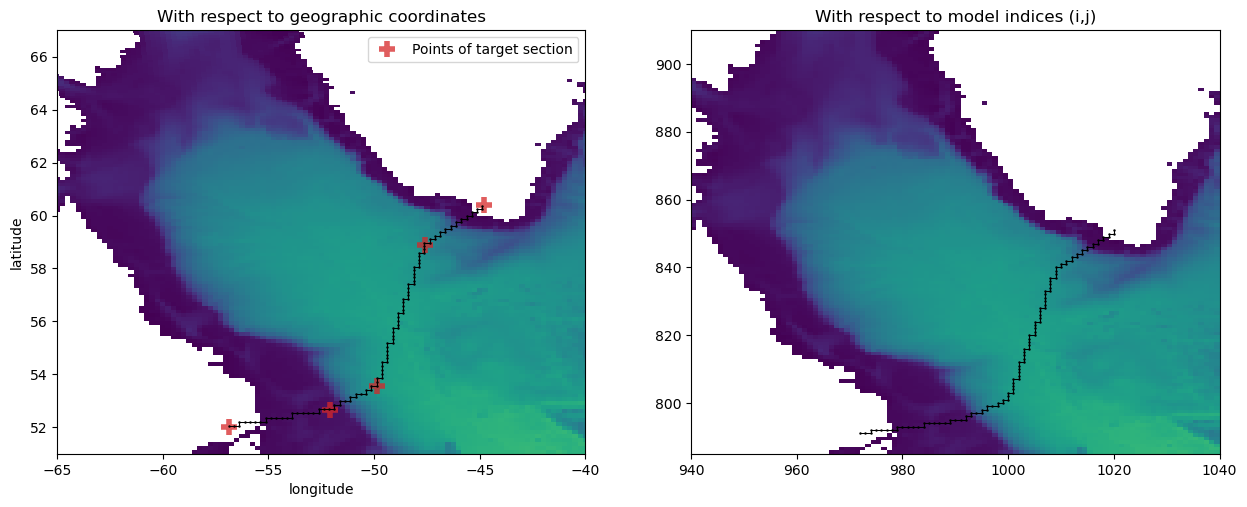

In [9]:
plt.figure(figsize=[15,5.5])
plt.subplot(1,2,1)
plt.pcolormesh(ds['geolon_c'], ds['geolat_c'], ds['deptho'].where(ds['deptho']!=0))
plt.plot(West_section_lons, West_section_lats, "C3+", markersize=12., mew=4., alpha=0.75, label="Points of target section")
plt.plot(xwest, ywest, 'k.-', markersize=1.5, lw=0.75)
plt.axis([-65,-40, 51, 67])
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("With respect to geographic coordinates")
plt.legend(loc="upper right")

plt.subplot(1,2,2)
plt.pcolormesh(ds['deptho'].where(ds['deptho']!=0).values)
plt.plot(iwest, jwest, 'k.-', markersize=1.5, lw=0.75)
plt.axis([940, 1040, 785, 910])
plt.title("With respect to model indices (i,j)")
plt.show()

### Plot the hydrography and cell-integrated mass transport across the section

In [10]:
T_west = sectionate.extract_tracer('thetao', grid, iwest, jwest)

In [11]:
Trp_west = sectionate.convergent_transport(grid, iwest, jwest)

/home/Henri.Drake/src/sectionate/sectionate/transports.py:263: UserWarning: The orientation of open sections is ambiguous–verify that it matches expectations!
  warnings.warn("The orientation of open sections is ambiguous–verify that it matches expectations!")


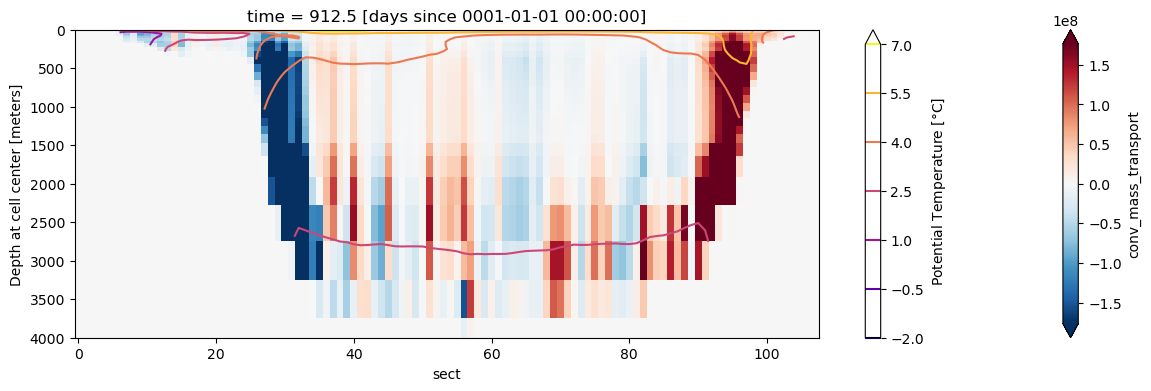

In [12]:
plt.figure(figsize=(15, 4))
Trp_west.isel(time=0)['conv_mass_transport'].swap_dims({'sect':'distance'}).plot(cmap='RdBu_r', x="distance", yincrease=False, ylim=[4000,0], robust=True)
cs = T_west.isel(time=0).plot.contour(vmin=-2, vmax=7, cmap='plasma', yincrease=False, ylim=[4000,0])
plt.colorbar(cs, label=r"Potential Temperature [$\degree$C]")

## East section

In [13]:
ieast, jeast, xeast, yeast = sectionate.grid_section(
    grid,
    East_section_lons,
    East_section_lats,
)

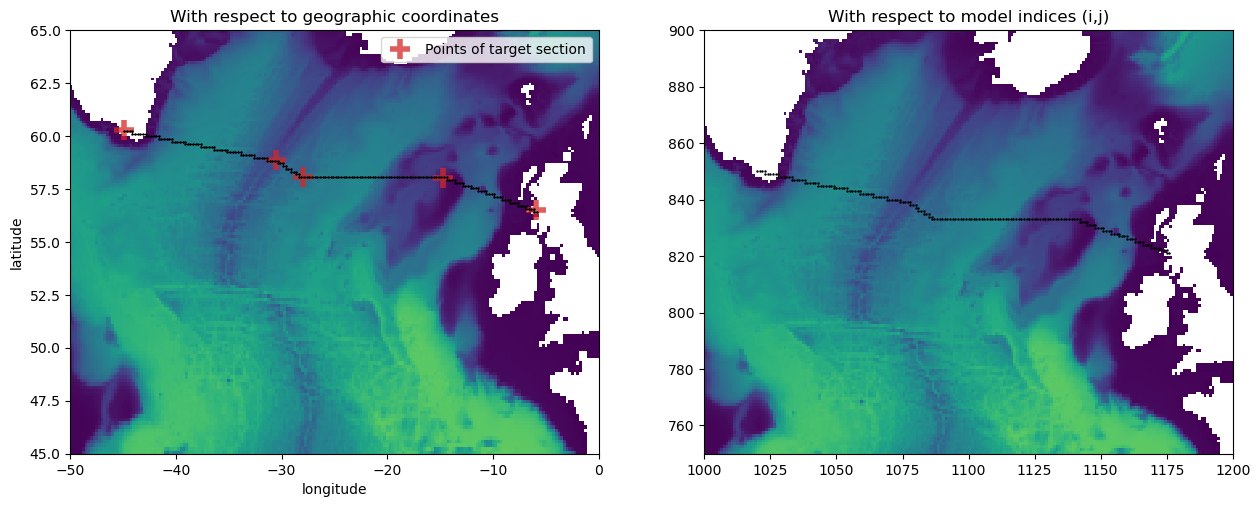

In [14]:
plt.figure(figsize=[15,5.5])
plt.subplot(1,2,1)
plt.pcolormesh(ds['geolon_c'], ds['geolat_c'], ds['deptho'].where(ds['deptho']!=0))
plt.plot(East_section_lons, East_section_lats, "C3+", markersize=15., mew=4., alpha=0.75, label="Points of target section")
plt.plot(xeast, yeast, 'k.-', markersize=1.5, lw=0.75)
plt.axis([-50, 0, 45, 65])
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("With respect to geographic coordinates")
plt.legend(loc="upper right")

plt.subplot(1,2,2)
plt.pcolormesh(ds['deptho'].where(ds['deptho']!=0))
plt.plot(ieast, jeast, 'k.', markersize=1.5, lw=0.75)
plt.axis([1000, 1200, 750, 900])
plt.title("With respect to model indices (i,j)")
plt.show()

### Plot the hydrography and cell-integrated mass transport across the section

In [15]:
T_east = sectionate.extract_tracer('thetao', grid, ieast, jeast)

In [16]:
Trp_east = sectionate.convergent_transport(grid, ieast, jeast)

/home/Henri.Drake/src/sectionate/sectionate/transports.py:263: UserWarning: The orientation of open sections is ambiguous–verify that it matches expectations!
  warnings.warn("The orientation of open sections is ambiguous–verify that it matches expectations!")


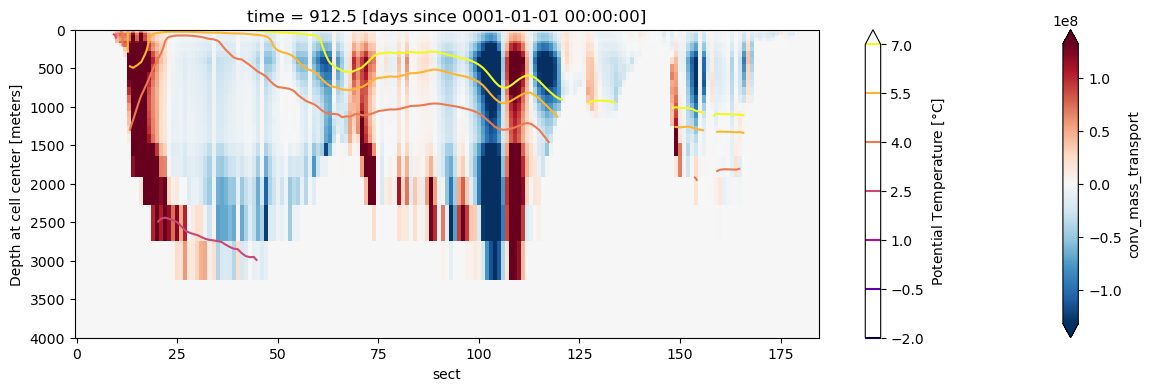

In [17]:
plt.figure(figsize=(15, 4))
Trp_east.isel(time=0)['conv_mass_transport'].plot(cmap='RdBu_r', yincrease=False, ylim=[4000,0], robust=True)
cs = T_east.isel(time=0).plot.contour(vmin=-2, vmax=7, cmap='plasma', yincrease=False, ylim=[4000,0])
plt.colorbar(cs, label=r"Potential Temperature [$\degree$C]")

## Diagnosing overturning streamfunctions in depth and density space

In [18]:
import xoverturning

In [19]:
names_z = {'x_center': 'sect',
         'layer': 'z_l',
         'interface': 'z_i'}

names_rho2 = {'x_center': 'sect',
              'layer': 'rho2_l',
              'interface': 'rho2_i'}

In [20]:
ovt_west = xoverturning.compfunc.compute_streamfunction(Trp_west, names_z, transport='conv_mass_transport', fromtop=True)

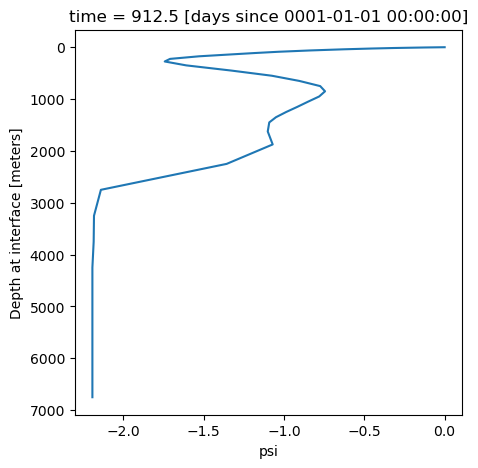

In [21]:
ovt_west.isel(time=0).plot(y='z_i', yincrease=False, figsize=[5,5])

In [22]:
ds_rho2 = xr.open_mfdataset(f"{dir_pp}/ocean_annual_rho2_d2/av/annual_5yr/*.nc", decode_times=False)
grid_rho2 = ds_to_grid(ds_rho2, ocean_grid)

In [23]:
Trp_rho2_west = sectionate.convergent_transport(grid_rho2, iwest, jwest, layer='rho2_l', interface='rho2_i')

/home/Henri.Drake/src/sectionate/sectionate/transports.py:263: UserWarning: The orientation of open sections is ambiguous–verify that it matches expectations!
  warnings.warn("The orientation of open sections is ambiguous–verify that it matches expectations!")


In [24]:
ovt_rho2_west = xoverturning.compfunc.compute_streamfunction(Trp_rho2_west, names_rho2, transport='conv_mass_transport', fromtop=True)

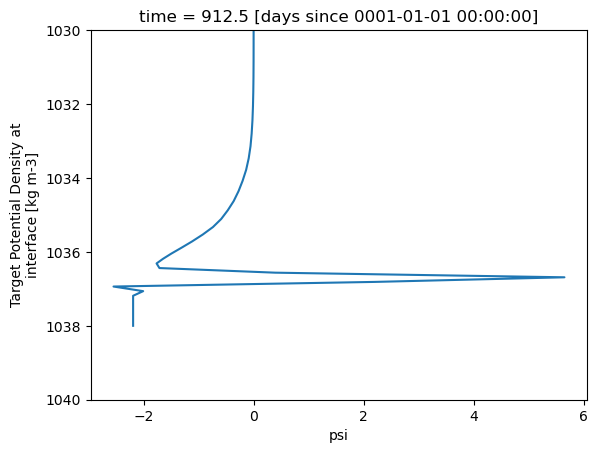

In [25]:
ovt_rho2_west.isel(time=0).plot(y='rho2_i', yincrease=False, ylim=[1040,1030])

In [26]:
Trp_rho2_east = sectionate.convergent_transport(grid_rho2, ieast, jeast, layer='rho2_l', interface='rho2_i')

/home/Henri.Drake/src/sectionate/sectionate/transports.py:263: UserWarning: The orientation of open sections is ambiguous–verify that it matches expectations!
  warnings.warn("The orientation of open sections is ambiguous–verify that it matches expectations!")


In [27]:
ovt_rho2_east = xoverturning.compfunc.compute_streamfunction(Trp_rho2_east, names_rho2, transport='conv_mass_transport', fromtop=True)

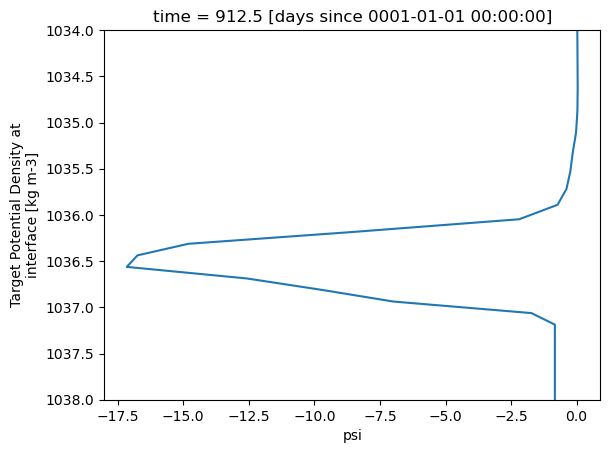

In [28]:
ovt_rho2_east.isel(time=0).plot(y='rho2_i', yincrease=False, ylim=[1038,1034])

In [29]:
np.isclose(ovt_west.isel(time=0).isel(z_i=-1).compute(), ovt_rho2_west.isel(time=0).isel(rho2_i=-1).compute(), rtol=1e-5)

True